In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from tqdm.auto import tqdm
import joblib
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
import time
from sklearn.metrics.pairwise import cosine_similarity
import smart_open
import gensim
import pickle
import os
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#os.chdir('/content/drive/My Drive/self_case_study1/data/VAE')

In [ ]:
df = pd.read_csv('/content/drive/My Drive/self_case_study1/data/all_data.csv')
df.head()

,id,title,body,tags,answers,score,tag_count
0,9,"In C#, how do I calculate someone's age based ...",<p>A given <code>DateTime</code> Type represen...,c#|.net|datetime,<p>The following approach (extract from <a hre...,4502,3
1,11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,c#|datetime|time|datediff|relative-time-span,<p>Is there an easy way to do this in Java? Th...,2327,5
2,126,How would you access Object properties from wi...,"<p>What is the ""purist"" or ""correct"" way to ac...",java|php|oop|theory,"<p>I can be wrong because I'm autodidact, but ...",262,4
3,330,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,c++|oop|class|nested-class,<p>You should use an inner class only when you...,63,4
4,742,Class views in Django,"<p><a href=""http://www.djangoproject.com/"" rel...",python|django|views|oop,<p>I've created and used my own generic view c...,73,4


In [ ]:
df.shape

(572554, 7)

In [ ]:
# below mentioned functions are helper functions which is use for text preprocessing
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\n", "", phrase)
    return phrase

def remove_code(text): 
    '''This function will remove code part and remove all html tags and return lower case text'''
    text = text.lower()
    # make it proper spaced text
    text = ' '.join(text.split())
    # remove code area from text and replace with space
    text = re.sub('<code>.*?</code>',' ',text)
    # remove all tags which are in "< >"
    text = re.sub('<.*?>',' ',text)
    # remove content between img tags
    text = re.sub('<img.*?>.*?</img>',' ',text)
    # remove content between a tag and URLs
    text = re.sub('<a.*?>.*?</a>',' ',text)
    # decontract text
    text = decontracted(text)
    # remove \n from text
    text = text.replace('\n',' ')
    # remove punctuations except c# and c++
    text = re.sub('[^A-Za-zc#c++]+',' ',text)
    return text.lower()

def remove_stopwords(text):
    '''this function will remove stopwords from text using nltk stopwords'''
    final_text = ''
    for word in text.split():
        if word not in stopwords.words('english'):
            final_text += word + ' '
    return final_text

def preprocess_text(text):
    '''this function will do all preprocessing'''
    # remove code part and punctuations
    removed_code = remove_code(text)
    # remove stopwords
    preprocessed_text = remove_stopwords(removed_code)
    # return cleaned text
    return preprocessed_text

def preprocess_title(text):
    # convert to lower case
    text = text.lower()
    # decontract
    text = decontracted(text)
    # remove all punctuations except a-z and c# and c++
    text = re.sub('[^a-zc#c++]+',' ',text)
    # remove stop words
    text = remove_stopwords(text)
    return text



* In Question body and answer body we have to remove code parts and we have to get only text part so we will remove code part and will remove html tags and all punctuations and we will get clean text in lower case.
*  We will add new column as preprocessed question body and preprocessed answer body.

In [ ]:
# remove code part from question body 
removed_code_questions = []
for i,row in tqdm(df.iterrows()):
    removed_code_questions.append(remove_code(row.body))

In [ ]:
# remove stopwords from removed_code_questions
preprocessed_questions = []
for i in tqdm(removed_code_questions):
    preprocessed_questions.append(remove_stopwords(i))


100%|██████████| 572554/572554 [1:13:31<00:00, 129.79it/s]


In [ ]:
# preprocess title
preprocessed_title = []
for i,row in tqdm(df.iterrows()):
    preprocessed_title.append(preprocess_title(row.title))

572554it [08:45, 1089.70it/s]


In [ ]:
# original title
df['title'][2]

'How would you access Object properties from within an object method?'

In [ ]:
# cleaned title
preprocessed_title[2]

'would access object properties within object method '

In [ ]:
# remove code from answers
removed_code_answers = []
for row in tqdm(df['answers']):
    removed_code_answers.append(remove_code(row))

100%|██████████| 572554/572554 [00:46<00:00, 12388.69it/s]


In [ ]:
# original answer at index 0
df['answers'][0]

'<p>The following approach (extract from <a href="https://www.codeproject.com/Articles/168662/Time-Period-Library-for-NET" rel="nofollow noreferrer">Time Period Library for .NET</a> class <em>DateDiff</em>) considers the calendar of the culture info:</p>\n\n<pre><code>// ----------------------------------------------------------------------\nprivate static int YearDiff( DateTime date1, DateTime date2 )\n{\n  return YearDiff( date1, date2, DateTimeFormatInfo.CurrentInfo.Calendar );\n} // YearDiff\n\n// ----------------------------------------------------------------------\nprivate static int YearDiff( DateTime date1, DateTime date2, Calendar calendar )\n{\n  if ( date1.Equals( date2 ) )\n  {\n    return 0;\n  }\n\n  int year1 = calendar.GetYear( date1 );\n  int month1 = calendar.GetMonth( date1 );\n  int year2 = calendar.GetYear( date2 );\n  int month2 = calendar.GetMonth( date2 );\n\n  // find the the day to compare\n  int compareDay = date2.Day;\n  int compareDaysPerMonth = calendar.G

In [ ]:
# answers after removing code
removed_code_answers[0]

' the following approach extract from time period library for net class datediff considers the calendar of the culture info usage here is a solution my suggestion that seems to have the year changing on the right date i spot tested up to age very simple answer here is a very simple and easy to follow example just use the current date get total hours and divide in the total hours per year and get exactly the age months days this may work here is a datetime extender that adds the age calculation to the datetime object this is one of the most accurate answers that is able to resolve the birthday of th of feb compared to any year of th feb do we need to consider people who is smaller than year as chinese culture we describe small babies age as months or weeks below is my implementation it is not as simple as what i imagined especially to deal with date like this implementation has passed below test cases hope it is helpful just because i do not think the top answer is that clear i often co

In [ ]:
# remove stopwords from answers
preprocessed_answers = []
for i in tqdm(removed_code_answers):
    preprocessed_answers.append(remove_stopwords(i))

100%|██████████| 572554/572554 [1:38:33<00:00, 96.82it/s] 


In [ ]:
df['answers'][0]

'<p>The following approach (extract from <a href="https://www.codeproject.com/Articles/168662/Time-Period-Library-for-NET" rel="nofollow noreferrer">Time Period Library for .NET</a> class <em>DateDiff</em>) considers the calendar of the culture info:</p>\n\n<pre><code>// ----------------------------------------------------------------------\nprivate static int YearDiff( DateTime date1, DateTime date2 )\n{\n  return YearDiff( date1, date2, DateTimeFormatInfo.CurrentInfo.Calendar );\n} // YearDiff\n\n// ----------------------------------------------------------------------\nprivate static int YearDiff( DateTime date1, DateTime date2, Calendar calendar )\n{\n  if ( date1.Equals( date2 ) )\n  {\n    return 0;\n  }\n\n  int year1 = calendar.GetYear( date1 );\n  int month1 = calendar.GetMonth( date1 );\n  int year2 = calendar.GetYear( date2 );\n  int month2 = calendar.GetMonth( date2 );\n\n  // find the the day to compare\n  int compareDay = date2.Day;\n  int compareDaysPerMonth = calendar.G

In [ ]:
preprocessed_answers[0]

'following approach extract time period library net class datediff considers calendar culture info usage solution suggestion seems year changing right date spot tested age simple answer simple easy follow example use current date get total hours divide total hours per year get exactly age months days may work datetime extender adds age calculation datetime object one accurate answers able resolve birthday th feb compared year th feb need consider people smaller year chinese culture describe small babies age months weeks implementation simple imagined especially deal date like implementation passed test cases hope helpful think top answer clear often count fingers need look calendar work things change would code running linqpad gives code linqpad easiest way answer single line also works leap years wow give answer many answers simple question made one small change mark soen answer rewriten third line expression parsed bit easily also made function sake clarity spent time working came ca

In [ ]:
# dump preprocessed question drive
joblib.dump(preprocessed_questions,'/content/drive/My Drive/self_case_study1/data/preprocessed_questions')

['/content/drive/My Drive/self_case_study1/data/preprocessed_questions']

In [ ]:
# dump preprocessed title in drive
joblib.dump(preprocessed_title,'/content/drive/My Drive/self_case_study1/data/preprocessed_title')

['/content/drive/My Drive/self_case_study1/data/preprocessed_title']

In [ ]:
# dump preprocessed answers in drive
joblib.dump(preprocessed_answers,'/content/drive/My Drive/self_case_study1/data/preprocessed_answers')

['/content/drive/My Drive/self_case_study1/data/preprocessed_answers']

In [ ]:
# load preprocessed questions
preprocessed_question = joblib.load('/content/drive/My Drive/self_case_study1/data/preprocessed_questions')

In [ ]:
print('Length of preprocessed questions = ',len(preprocessed_question))

Length of preprocessed questions =  572554


In [ ]:
# load preprocessed titles
preprocessed_title = joblib.load('/content/drive/My Drive/self_case_study1/data/preprocessed_title')

In [ ]:
print('Length of preprocessed titles= ',len(preprocessed_title))

Length of preprocessed titles=  572554


In [ ]:
# load preprocessed answers
preprocessed_answer = joblib.load('/content/drive/My Drive/self_case_study1/data/preprocessed_answers')

In [ ]:
print('Length of preprocessed answers= ',len(preprocessed_answer))

Length of preprocessed answers=  572554


In [ ]:
tags = df['tags']
id = df['id']
score = df['score']

In [ ]:
Dict = { 'id' : id,
         'preprocessed_title' : preprocessed_title,
         'preprocessed_question': preprocessed_question,
         'preprocessed_answer' : preprocessed_answer,
         'score' : score,
         'tags': tags}
preprocessed_df = pd.DataFrame(Dict)

In [ ]:
# save as csv
# preprocessed_df.to_csv('/content/drive/My Drive/self_case_study1/data/preprocessed_df.csv',index=False)

## Load preprocesed data

In [ ]:
preprocessed_df = pd.read_csv('/content/drive/My Drive/self_case_study1/data/preprocessed_df.csv')
preprocessed_df.head()

,id,preprocessed_title,preprocessed_question,preprocessed_answer,score,tags
0,9,c# calculate someone age based datetime type b...,given type representing person birthday calcul...,following approach extract time period library...,4502,c#|.net|datetime
1,11,calculate relative time c#,given specific value display relative time lik...,easy way java class seems rather limited quick...,2327,c#|datetime|time|datediff|relative-time-span
2,126,would access object properties within object m...,purist correct way access object properties wi...,wrong autodidact never user public properties ...,262,java|php|oop|theory
3,330,use nested classes case,working collection classes used video playback...,use inner class cannot implement separate clas...,63,c++|oop|class|nested-class
4,742,class views django,django view points function problem want chang...,created used generic view classes defining ins...,73,python|django|views|oop


In [ ]:
# cheking for null values
print('Total null values in preprocessed titles =',preprocessed_df['preprocessed_title'].isna().sum())
print('Total null values in preprocessed questions =',preprocessed_df['preprocessed_question'].isna().sum())
print('Total null values in preprocessed answers =',preprocessed_df['preprocessed_answer'].isna().sum())
print('Total null values in score =',preprocessed_df['score'].isna().sum())
print('Total null values in tags =',preprocessed_df['tags'].isna().sum())

Total null values in preprocessed titles = 5
Total null values in preprocessed questions = 390
Total null values in preprocessed answers = 3436
Total null values in score = 0
Total null values in tags = 1


In [ ]:
# concatenate title and question body 
preprocessed_df['question_content'] = preprocessed_df['preprocessed_title'].fillna('') + ' ' + preprocessed_df['preprocessed_question'].fillna('')

In [ ]:
# remove all character  which has length 1
def remove_single_char(text):
    l = [word for word in str(text).split() if len(word) > 1]
    return ' '.join(l)

In [ ]:
# remove words with length 1 from question content and answer
preprocessed_df['question_content'] = preprocessed_df['question_content'].apply(lambda x: remove_single_char(x))
preprocessed_df['preprocessed_answer'] = preprocessed_df['preprocessed_answer'].apply(lambda x: remove_single_char(x))

In [ ]:
# concatenate question content and preprocessed answer
preprocessed_df['all_text'] = preprocessed_df['question_content'].fillna('')+' '+preprocessed_df['preprocessed_answer'].fillna('')

In [ ]:
preprocessed_df.head()

,id,preprocessed_title,preprocessed_question,preprocessed_answer,score,tags,question_content,all_text
0,9,c# calculate someone age based datetime type b...,given type representing person birthday calcul...,following approach extract time period library...,4502,c#|.net|datetime,c# calculate someone age based datetime type b...,c# calculate someone age based datetime type b...
1,11,calculate relative time c#,given specific value display relative time lik...,easy way java class seems rather limited quick...,2327,c#|datetime|time|datediff|relative-time-span,calculate relative time c# given specific valu...,calculate relative time c# given specific valu...
2,126,would access object properties within object m...,purist correct way access object properties wi...,wrong autodidact never user public properties ...,262,java|php|oop|theory,would access object properties within object m...,would access object properties within object m...
3,330,use nested classes case,working collection classes used video playback...,use inner class cannot implement separate clas...,63,c++|oop|class|nested-class,use nested classes case working collection cla...,use nested classes case working collection cla...
4,742,class views django,django view points function problem want chang...,created used generic view classes defining ins...,73,python|django|views|oop,class views django django view points function...,class views django django view points function...


#### Checking for null values in question content

In [ ]:
# checking in preprocessed_df for null titles
preprocessed_df['question_content'].isna().sum()

0

#### Checking for null values in all text

In [ ]:
# checking in preprocessed_df for null answers
preprocessed_df['all_text'].isna().sum()

0

In [ ]:
preprocessed_df['all_text'][0]

'c# calculate someone age based datetime type birthday given type representing person birthday calculate age years following approach extract time period library net class datediff considers calendar culture info usage solution suggestion seems year changing right date spot tested age simple answer simple easy follow example use current date get total hours divide total hours per year get exactly age months days may work datetime extender adds age calculation datetime object one accurate answers able resolve birthday th feb compared year th feb need consider people smaller year chinese culture describe small babies age months weeks implementation simple imagined especially deal date like implementation passed test cases hope helpful think top answer clear often count fingers need look calendar work things change would code running linqpad gives code linqpad easiest way answer single line also works leap years wow give answer many answers simple question made one small change mark soen 

# Analysis of question content

In [ ]:
# import FreqDist from nltk library to get word frequency from given text
from nltk import FreqDist

In [ ]:
# get one single list of whole corpus words
all_words = []
for line in tqdm(preprocessed_df['question_content']):
    all_words.extend(line.split())    

In [ ]:
# get frequency distribution of all words
word_freq = FreqDist(all_words) 
print('Number of unique words = ',len(word_freq))

Number of unique words =  356348


In [ ]:
# cheecking last 5 words from most common words
word_freq.most_common(20000)[-5:]

[('collectstatic', 30),
 ('cloudsearch', 30),
 ('pingfederate', 30),
 ('isnumber', 30),
 ('crl', 30)]

here we are taking top 20000 words because last 5 words of top 20000 words are occuring atleasr 30 times

In [ ]:
# top 20000 words
top_k_words = dict(word_freq.most_common(20000)).keys()

In [ ]:
# set of top k words 
top_k_words = set(top_k_words)
print('Length of top k words is = ', len(top_k_words))

Length of top k words is =  20000


In [ ]:
def keep_top_k_words(text):
    ''' This function will keep only top k words'''
    top_k =  [word for word in text.split() if word in top_k_words]
    return ' '.join(top_k)

In [ ]:
# apply keep top words function on question content
preprocessed_df['question_content'] = preprocessed_df['question_content'].apply(lambda x : keep_top_k_words(x))

### Analysis on question content length

In [ ]:
# make column of question content length
preprocessed_df['question_length'] = preprocessed_df['question_content'].apply(lambda x: len(x.split()))

In [ ]:
preprocessed_df.head()

,id,preprocessed_title,preprocessed_question,preprocessed_answer,score,tags,question_content,all_text,question_length
0,9,c# calculate someone age based datetime type b...,given type representing person birthday calcul...,following approach extract time period library...,4502,c#|.net|datetime,c# calculate someone age based datetime type b...,c# calculate someone age based datetime type b...,16
1,11,calculate relative time c#,given specific value display relative time lik...,easy way java class seems rather limited quick...,2327,c#|datetime|time|datediff|relative-time-span,calculate relative time c# given specific valu...,calculate relative time c# given specific valu...,17
2,126,would access object properties within object m...,purist correct way access object properties wi...,wrong autodidact never user public properties ...,262,java|php|oop|theory,would access object properties within object m...,would access object properties within object m...,96
3,330,use nested classes case,working collection classes used video playback...,use inner class cannot implement separate clas...,63,c++|oop|class|nested-class,use nested classes case working collection cla...,use nested classes case working collection cla...,82
4,742,class views django,django view points function problem want chang...,created used generic view classes defining ins...,73,python|django|views|oop,class views django django view points function...,class views django django view points function...,56


In [ ]:
preprocessed_df.shape

(572554, 9)

In [ ]:
print('50th percentile of question lenght is ==>',np.percentile(preprocessed_df['question_length'],50))
print('75th percentile of question lenght is ==>',np.percentile(preprocessed_df['question_length'],75))
print('90th percentile of question lenght is ==>',np.percentile(preprocessed_df['question_length'],90))
print('95th percentile of question lenght is ==>',np.percentile(preprocessed_df['question_length'],95))
print('98th percentile of question lenght is ==>',np.percentile(preprocessed_df['question_length'],98))

50th percentile of question lenght is ==> 41.0
75th percentile of question lenght is ==> 60.0
90th percentile of question lenght is ==> 87.0
95th percentile of question lenght is ==> 109.0
98th percentile of question lenght is ==> 143.0


## plot CDF of question length

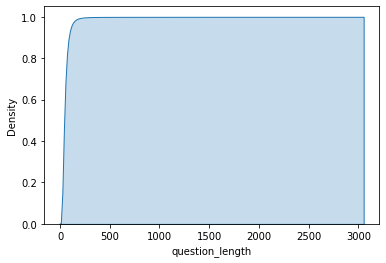

In [ ]:
import seaborn as sns
sns.kdeplot(preprocessed_df['question_length'],cumulative=True,shade=True)

### as we can see 75th percent of question length are 60 or less then 60 so we will consider all questions which have length less then or equal to 60. 

In [ ]:
print('Total number of rows which have question length greater then 60 is  =======>')
print(preprocessed_df[preprocessed_df['question_length']>60].shape[0])

Total number of rows which have question length greater then 60 is  =======>
84586


In [ ]:
preprocessed_df = preprocessed_df[preprocessed_df['question_length']<60]
print('Total number of rows in preprocessed_df after dropping large length question = ', preprocessed_df.shape[0])

Total number of rows in preprocessed_df after dropping large length question =  425167


In [ ]:
# reset index
preprocessed_df.reset_index(drop=True,inplace=True)

In [ ]:
preprocessed_df.head()

,id,preprocessed_title,preprocessed_question,preprocessed_answer,score,tags,question_content,all_text,question_length
0,9,c# calculate someone age based datetime type b...,given type representing person birthday calcul...,following approach extract time period library...,4502,c#|.net|datetime,c# calculate someone age based datetime type b...,c# calculate someone age based datetime type b...,16
1,11,calculate relative time c#,given specific value display relative time lik...,easy way java class seems rather limited quick...,2327,c#|datetime|time|datediff|relative-time-span,calculate relative time c# given specific valu...,calculate relative time c# given specific valu...,17
2,742,class views django,django view points function problem want chang...,created used generic view classes defining ins...,73,python|django|views|oop,class views django django view points function...,class views django django view points function...,56
3,2214,best way implement bdd tdd net,looking add testing suite application however ...,using nunit tfs difficult even project codeple...,52,c#|.net|testing|tdd|bdd,best way implement bdd tdd net looking add tes...,best way implement bdd tdd net looking add tes...,23
4,2509,primary differences tdd bdd,test driven development rage net community las...,short major difference tdd bdd tdd majorly foc...,159,unit-testing|tdd|bdd,primary differences tdd bdd test driven develo...,primary differences tdd bdd test driven develo...,20


In [ ]:
# save final featurized dataframe
#preprocessed_df.to_csv('/content/drive/My Drive/self_case_study1/data/featurized_df.csv',index=False)

In [ ]:
#featurized_df = pd.read_csv('/content/drive/My Drive/self_case_study1/data/featurized_df.csv')

In [ ]:
print('Shape of featurized_df is ===> ',featurized_df.shape)

Shape of featurized_df is ===>  (425167, 9)


In [ ]:
featurized_df.head(3)

,id,preprocessed_title,preprocessed_question,preprocessed_answer,score,tags,question_content,all_text,question_length
0,9,c# calculate someone age based datetime type b...,given type representing person birthday calcul...,following approach extract time period library...,4502,c#|.net|datetime,c# calculate someone age based datetime type b...,c# calculate someone age based datetime type b...,16
1,11,calculate relative time c#,given specific value display relative time lik...,easy way java class seems rather limited quick...,2327,c#|datetime|time|datediff|relative-time-span,calculate relative time c# given specific valu...,calculate relative time c# given specific valu...,17
2,742,class views django,django view points function problem want chang...,created used generic view classes defining ins...,73,python|django|views|oop,class views django django view points function...,class views django django view points function...,56


In [ ]:
# create dataframe of original title and id
title_df = df[['id','title']]
title_df.head()

,id,title
0,9,"In C#, how do I calculate someone's age based ..."
1,11,Calculate relative time in C#
2,126,How would you access Object properties from wi...
3,330,Should I use nested classes in this case?
4,742,Class views in Django


In [ ]:
# attach original title column using merge operation on id

featurized_df = featurized_df.merge(title_df,on='id')

In [ ]:
featurized_df.head(2)

,id,preprocessed_title,preprocessed_question,preprocessed_answer,score,tags,question_content,all_text,question_length,title
0,9,c# calculate someone age based datetime type b...,given type representing person birthday calcul...,following approach extract time period library...,4502,c#|.net|datetime,c# calculate someone age based datetime type b...,c# calculate someone age based datetime type b...,16,"In C#, how do I calculate someone's age based ..."
1,11,calculate relative time c#,given specific value display relative time lik...,easy way java class seems rather limited quick...,2327,c#|datetime|time|datediff|relative-time-span,calculate relative time c# given specific valu...,calculate relative time c# given specific valu...,17,Calculate relative time in C#


### Save final featurized data with original title as csv

In [ ]:
# save final dataframe
featurized_df.to_csv('/content/drive/My Drive/self_case_study1/data/featurized_data.csv',index=False)

#### Load featurized dataframe

In [2]:
# load final featurized dataframe
featurized_df = pd.read_csv('/content/drive/My Drive/self_case_study1/data/featurized_data.csv')

In [3]:
from sklearn.model_selection import train_test_split
X_train,X_test = train_test_split(featurized_df,test_size=0.5,random_state=42)

# reset index of train and test
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

print('Shape of X_train',X_train.shape)
print('Shape of X_test',X_test.shape)

Shape of X_train (212583, 10)
Shape of X_test (212584, 10)


In [5]:
X_train.head()

,id,preprocessed_title,preprocessed_question,preprocessed_answer,score,tags,question_content,all_text,question_length,title
0,63161427,react navigation cangoback stack navigator,using react navigation app tab navigator conta...,found solution line allows check deep inside s...,0,reactjs|react-native|react-navigation|react-na...,react navigation stack navigator using react n...,react navigation cangoback stack navigator usi...,47,React navigation 5 canGoBack() for stack navig...
1,61920795,display field edit form,currently try place field edit form field disp...,need pass record prop basepath reference edit ...,1,react-admin,display field edit form currently try place fi...,display field edit form currently try place fi...,28,Display Field in Edit Form
2,61402494,keep border primarycolor,trying set flutter focus turns primarycolor ho...,stop border color changing add need wrap textf...,1,flutter,keep border trying set flutter focus turns how...,keep border primarycolor trying set flutter fo...,21,How to keep border primaryColor
3,28564564,load image work emulator,trying get image load onto app imageview howev...,saying app working emulator something permissi...,1,java|android|xml|imageview,load image work emulator trying get image load...,load image work emulator trying get image load...,39,Why does Load image work on emulator but not o...
4,3785444,stop running method,want stop currently running method short durat...,always use functions might convenient methods ...,2,objective-c,stop running method want stop currently runnin...,stop running method want stop currently runnin...,13,to stop a running method


### **Model-1 : TFIDF word2vec using pretrained glove model**

In [ ]:
# function to load glove vectors
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('/content/drive/My Drive/Glove_42B/glove.42B.300d.txt')

Loading Glove Model



Done. 1917494  words loaded!


In [ ]:
# get list of lists for every sentence words
words = []
for line in tqdm(X_train['question_content']):
    words.append(line.split())

In [ ]:
len(words)

212583

In [ ]:
# get one single list of whole corpus words
Words = []
for line in tqdm(X_train['question_content']):
    Words.extend(line.split())

In [ ]:
print("All the words in the courpus", len(Words))
Words = set(Words)
print("The unique words in the courpus", len(Words))
inter_words = set(model.keys()).intersection(Words)
print("The number of words that are present in both glove vectors and our courpus", \
len(inter_words),"(",np.round(len(inter_words)/len(Words)*100,3),"%)")

All the words in the courpus 7340998
The unique words in the courpus 19725
The number of words that are present in both glove vectors and our courpus 18546 ( 94.023 %)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=10)
# fit and transform on question content
tfidf.fit_transform(X_train["question_content"])

<212583x14175 sparse matrix of type '<class 'numpy.float64'>'
	with 5440200 stored elements in Compressed Sparse Row format>

In [ ]:
# save tfidf 
joblib.dump(tfidf,'/content/drive/My Drive/self_case_study1/data/joblib_dumps_glove_model/tfidf1')

['/content/drive/My Drive/self_case_study1/data/joblib_dumps_glove_model/tfidf1']

In [ ]:
len(tfidf_words)

14175

In [ ]:
words_courpus = {}
words_glove = set(model.keys())
for i in Words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('/content/drive/My Drive/self_case_study1/data/joblib_dumps_glove_model/glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)


word 2 vec length 18546


## load glove vectors

In [ ]:
with open('/content/drive/My Drive/self_case_study1/data/joblib_dumps_glove_model/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

In [ ]:
# we are converting a dictionary with word as a key, and the idf as a value
tfidf = joblib.load('/content/drive/My Drive/self_case_study1/data/joblib_dumps_glove_model/tfidf1')
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_words = set(tfidf.get_feature_names())

In [ ]:

tfidf_w2v_vector = [] # the weighted w2v for each sentence is stored in this list
for sentence in tqdm(words): # for each sentence words list
    vector = np.zeros(300) # as word vectors length is 300
    tf_idf_weight =0; # num of words with a valid vector in the sentence
    for word in sentence : # for each word in a review/sentence
        if (word in glove_words ) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # multiply idf value of word with tf of word
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence))
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vector.append(vector)

In [ ]:
# save tfidf w2v vectors
joblib.dump(tfidf_w2v_vector,'/content/drive/My Drive/self_case_study1/data/joblib_dumps_glove_model/tfidf_w2v_vector_glove')

['/content/drive/My Drive/self_case_study1/data/joblib_dumps_glove_model/tfidf_w2v_vector_glove']

In [ ]:
# load tfidf w2v vectors
tfidf_w2v_vector = joblib.load('/content/drive/My Drive/self_case_study1/data/joblib_dumps_glove_model/tfidf_w2v_vector_glove')

In [ ]:
# query question
text = 'how to make dictionary in python language'
text

'how to make dictionary in python language'

In [ ]:
# get glove words
#glove_words = set(model.keys())
# get tfidf words
#tfidf_words = set(tfidf.get_feature_names())
# dictionary of tfidf
#dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))


def find_similarity(question,top_n):
    ''' This function will find top similar result for given query'''
    start = time.time()
    # initialize  vector for user query
    main_vec = np.zeros(300)
    # initialize tfidf weight
    weight_sum = 0
    # preprocess question
    text = preprocess_title(question)
    #splitting the sentence
    text_list = list(text.split())
    for word in text_list:
        #finding if word is present in tfidf and in w2v words
        if word in tfidf_words and word in glove_words :
            #finding vector of word from glove model
            vect = model[word]
            #compute tfidf
            tf_idf = dictionary[word]*(text_list.count(word)/len(text_list)) 
            # adding vector * tfidf to main_vec
            main_vec+= (vect*tf_idf)
            # summing tfidf values
            weight_sum += tf_idf
    if weight_sum !=0:
        # devide by weight_sum
        main_vec /= weight_sum
    # find cosine similarity
    similarities =  cosine_similarity((main_vec).reshape(1, -1), Y=tfidf_w2v_vector, dense_output=True)
    # sort similarities 
    #print(similarities[0])
    
    sort = np.argsort(similarities[0])
    # get top similarity indices  in descending order
    similarity_index = np.array(list(reversed(sort)))
    # finad top n similarities
    top_similarity_index = similarity_index[:top_n]
    # print top similarity values
    print('Top cosine similarities are ======>',similarities[0][top_similarity_index])
    # get original title of similar questions
    similar_questions = X_train['title'][top_similarity_index]
    #print(similar_questions)
    
    similar_question_list = []
    for q in similar_questions:
        similar_question_list.append(q)
        #print(q)
    total_time = (time.time() - start)
    print('Total time ===========> ',total_time)
    return similar_question_list


In [ ]:
top_10_questions = find_similarity(text,10)

Top cosine similarities are ======> [0.91009833 0.90754653 0.90387262 0.8991957  0.8973932  0.89601402
 0.89469953 0.89280858 0.8910764  0.88964025]
Total time ===========>  1.4789988994598389


In [ ]:
print('Top 10 similar questions Using weighted TFIDF and Glove vectors')
print('='*100)
print('\t')
for i,line in enumerate(top_10_questions):
    print('Question {} ===> {}'.format(i+1,line))
    print('='*100)

Top 10 similar questions Using weighted TFIDF and Glove vectors
	
Question 1 ===> Handling dictionary object in python
Question 2 ===> Need help in translating language function in wordpress
Question 3 ===> Creating a words game in Java(Issues with dictionary File organisation)
Question 4 ===> Iteration of a nested dictionary in Python 3
Question 5 ===> Expressjs language library
Question 6 ===> How can I create a dictionary within another dictionary with count capability?
Question 7 ===> is it possible to reverse a dictionary in python using dictionary comprehension
Question 8 ===> WPF spell check specific language
Question 9 ===> How to change android app language without changing phone language?
Question 10 ===> import nested dictionary in pandas (from yaml)


# Model-2 : train word2vec using gensim

In [ ]:
from gensim.models import Word2Vec

In [ ]:
# train Word2vec model with vector size 60
w2v_model = Word2Vec(words,size=60,min_count=10, workers=-1,iter=50)

In [ ]:
word_vectors = w2v_model.wv

In [ ]:
# shape of w2v vectors
word_vectors.vectors.shape

(16226, 60)

In [ ]:
# save word2vec model
joblib.dump(w2v_model,'/content/drive/My Drive/self_case_study1/data/joblib_dumps/gensim_w2v_model')

['/content/drive/My Drive/self_case_study1/data/joblib_dumps/gensim_w2v_model']

In [ ]:
# get word2vec vocab
w2v_words = list(w2v_model.wv.vocab)
print("sample words =====>", w2v_words[0:10])

sample words =====> ['react', 'navigation', 'stack', 'navigator', 'using', 'app', 'tab', 'contains', 'want', 'use']


In [ ]:
# number of unique word in word2vec vocab
print('Number of unique words in Word2vec ==> ',len(w2v_words))

Number of unique words in Word2vec ==>  16226


In [ ]:
# Words list have all the words which are in corpus
print("All the words in the courpus", len(Words))
# unique words from whole X_train
Words = set(Words)
print("The unique words in the courpus", len(Words))
# common word of w2v_words and Words
inter_words = set(w2v_words).intersection(Words)
print("The number of words that are present in both glove vectors and our courpus", \
len(inter_words),"(",np.round(len(inter_words)/len(Words)*100,3),"%)")

All the words in the courpus 19725
The unique words in the courpus 19725
The number of words that are present in both glove vectors and our courpus 16226 ( 82.261 %)


### **TF-IDF weighted W2V using gensim**

In [ ]:
# dictionary in which word as key and idf as value
dictionary = dict(zip(tfidf.get_feature_names(),tfidf.idf_))

In [ ]:
# check for random word
dictionary['samsung']

8.256457189259862

In [ ]:
# number of words in dictionary
len(dictionary)

14175

In [ ]:
# get tfidf words
tfidf_words = set(tfidf.get_feature_names())

In [ ]:
tfidf_w2v_vectors_gensim = [] # the weighted w2v for each sentence is stored in this list
for sentence in tqdm(words): # for each sentence
    vector = np.zeros(60) # as word vectors length is 60
    tf_idf_weight =0; # num of words with a valid vector in the sentence
    for word in sentence : # for each word in a review/sentence
        if (word in w2v_words) and (word in tfidf_words):
            vec = w2v_model.wv[word] # getting the vector for each word
            # multiply idf value of word with tf of word
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence))
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_gensim.append(vector)


In [ ]:
len(tfidf_w2v_vectors_gensim)

212583

In [ ]:
# save tfidf w2v vectors using gensim
joblib.dump(tfidf_w2v_vectors_gensim,'/content/drive/My Drive/self_case_study1/data/joblib_dumps/tfidf_w2v_vectors_gensim')

['/content/drive/My Drive/self_case_study1/data/joblib_dumps/tfidf_w2v_vectors_gensim']

In [ ]:
# total number of vectors 
print('Total number of vectors = ',len(tfidf_w2v_vectors_gensim))
# length of single vector
print('Size of single vector = ',len(tfidf_w2v_vectors_gensim[0]))

Total number of vectors =  212583
Size of single vector =  60


##### **Load all saved files**

In [ ]:
tfidf_gensim = joblib.load('/content/drive/My Drive/self_case_study1/data/joblib_dumps_glove_model/tfidf1')
w2v_model_gensim = joblib.load('/content/drive/My Drive/self_case_study1/data/joblib_dumps/gensim_w2v_model')
tfidf_w2v_vectors_gensim = joblib.load('/content/drive/My Drive/self_case_study1/data/joblib_dumps/tfidf_w2v_vectors_gensim')

In [ ]:
# w2vec words vocabulary
w2v_words = list(w2v_model_gensim.wv.vocab)
# tfidf words
tfidf_words = set(tfidf_gensim.get_feature_names())
# dictionary of tfidf and idf values
dictionary = dict(zip(tfidf_gensim.get_feature_names(),tfidf_gensim.idf_))

In [ ]:
text = 'how to make dictionary in python language'

In [ ]:
def find_similarity_gensim_trained(question,top_n):
    ''' This function will find top similar result for given query using gensim w2v'''
    start = time.time()
    # initialize  vector for user query
    main_vec = np.zeros(60)
    # initialize tfidf weight
    weight_sum = 0
    # preprocess question
    text = preprocess_title(question)
    #splitting the sentence
    text_list = list(text.split())
    for word in text_list:
        #finding if word is present in tfidf and in w2v words
        if word in tfidf_words and word in w2v_words :
            #finding vector of word from glove model
            vect = w2v_model_gensim[word]
            #compute tfidf
            tf_idf = dictionary[word]*(text_list.count(word)/len(text_list)) 
            # adding vector * tfidf to main_vec
            main_vec+= (vect*tf_idf)
            # summing tfidf values
            weight_sum += tf_idf
    if weight_sum !=0:
        # devide by weight_sum
        main_vec /= weight_sum
    # find cosine similarity
    # tfidf word2vec have trained using gensim
    similarities =  cosine_similarity((main_vec).reshape(1, -1), Y=tfidf_w2v_vectors_gensim, dense_output=True)
    # sort similarities 
    sort = np.argsort(similarities[0])
    # get top similarity indices  in descending order
    similarity_index = np.array(list(reversed(sort)))
    # find top n similarities
    top_similarity_index = similarity_index[:top_n]
    # print top similarity values
    print('Top cosine similarities are ======>',similarities[0][top_similarity_index])
    similar_questions = X_train['title'][top_similarity_index]
    #print(similar_questions)
    similar_question_list = []
    for q in similar_questions:
        similar_question_list.append(q)
        #print(q)
    total_time = (time.time() - start)
    print('\t')
    print('Total time ===========> ',total_time)
    return similar_question_list

In [ ]:
top_10_similar_q = find_similarity_gensim_trained(text,10)

Top cosine similarities are ======> [0.68738857 0.68549072 0.68354058 0.67859164 0.67791326 0.67589463
 0.67470356 0.67330233 0.66850379 0.66690239]
	
Total time ===========>  0.3199794292449951


In [ ]:
print('Top 10 similar questions Using weighted TFIDF and gensim Word2Vec')
print('='*100)
print('\t')
for i,line in enumerate(top_10_similar_q):
    print('Question {} ===> {}'.format(i+1,line))
    print('='*100)

Top 10 similar questions Using weighted TFIDF and gensim Word2Vec
	
Question 1 ===> write a dictionary of dictionaries (with unknown size) as a matrix
Question 2 ===> how to order a dictionary based on key by daywise in python
Question 3 ===> Handling dictionary object in python
Question 4 ===> import nested dictionary in pandas (from yaml)
Question 5 ===> How to get a dictionary source?
Question 6 ===> How to retrieve data from Dictionary class in java
Question 7 ===> iOS how can I dump multiple properties of an object into a dictionary using a predicate or KVC?
Question 8 ===> How to iterate through list and populated nested dictionary Python?
Question 9 ===> Getting Json dictionary/list values python
Question 10 ===> Append lines from .gz file to dictionary python


# Model-3 : Doc2Vec
Reference : https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py

**There are two implementations:**

    1. Paragraph Vector - Distributed Memory (PV-DM)

    2. Paragraph Vector - Distributed Bag of Words (PV-DBOW)

In [ ]:
def read_corpus(filename, tokens_only=False):
    for i, line in tqdm(enumerate(filename)):
        tokens = gensim.utils.simple_preprocess(line)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])


In [ ]:
# train corpus
train_corpus = list(read_corpus(X_train['question_content']))

In [ ]:
# check for first 5 questions
train_corpus[:5]

[TaggedDocument(words=['react', 'navigation', 'stack', 'navigator', 'using', 'react', 'navigation', 'app', 'tab', 'navigator', 'contains', 'stack', 'navigator', 'want', 'use', 'stack', 'navigator', 'user', 'top', 'screen', 'stack', 'nav', 'going', 'back', 'stack', 'want', 'return', 'false', 'way', 'works', 'always', 'true', 'unless', 'first', 'tab', 'screen', 'app', 'starts', 'takes', 'different', 'tabs', 'solution', 'work', 'around', 'help', 'highly', 'appreciated'], tags=[0]),
 TaggedDocument(words=['display', 'field', 'edit', 'form', 'currently', 'try', 'place', 'field', 'edit', 'form', 'field', 'display', 'errors', 'console', 'terminal', 'wont', 'example', 'display', 'either', 'page', 'load', 'simply', 'blank', 'way', 'use', 'fields', 'edit', 'form'], tags=[1]),
 TaggedDocument(words=['keep', 'border', 'trying', 'set', 'flutter', 'focus', 'turns', 'however', 'would', 'like', 'keep', 'border', 'titles', 'whenever', 'focused', 'expect', 'color', 'change', 'border', 'titles', 'write']

In [ ]:
X_train.shape

(212583, 9)

### Training the model

In [ ]:
# define model
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=10, epochs=60,workers=-1)

In [ ]:
# build vocab
model.build_vocab(train_corpus)
#Essentially, the vocabulary is a dictionary (accessible via model.wv.vocab) of all of the unique words extracted 
#from the training corpus along with the count (e.g., model.wv.vocab['penalty'].count for counts for the word penalty).

In [ ]:
# count of word python in vocab
print(model.wv.vocab['python'])

Vocab(count:15044, index:71, sample_int:4294967296)


In [ ]:
print(model.corpus_count)

212583


In [ ]:
# train model
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
# save model
joblib.dump(model,'/content/drive/My Drive/self_case_study1/data/doc2vec/doc2vecmodel')

['/content/drive/My Drive/self_case_study1/data/doc2vec/doc2vecmodel']

In [ ]:
# load model 
model = joblib.load('/content/drive/My Drive/self_case_study1/data/doc2vec/doc2vecmodel')

In [ ]:
# shape of the vector
model.docvecs[0].shape

(100,)

In [ ]:
test_corpus = list(read_corpus('how to make dictionary in python', tokens_only=True))
vector = model.infer_vector(test_corpus[0])
simi = (model.docvecs.most_similar([vector], topn=10))#this algorithm by default calculates cosine similarity as a distance metric
print(simi)


[(183610, 0.43154197931289673), (196860, 0.4177968204021454), (127069, 0.40544310212135315), (176202, 0.4016878306865692), (181276, 0.39809274673461914), (129982, 0.3949902653694153), (132343, 0.3900105357170105), (10880, 0.385919451713562), (184499, 0.3844781219959259), (113944, 0.38275274634361267)]


In [ ]:
sim_doc2vec = []
for i in range(len(simi)):
  idx = (simi[i][0])
  se = X_train["title"][idx]
  print(se)
  print('='*100)
  #sim_doc2vec.append(se)

Multiple Parameters with POST and MVC
Center menu items in responsive navbar
pandas write dataframe to parquet format with append
Load VideoJS with AJAX
How to prepopulate form in struts2 from database values
Jqgrid - How to perform search locally for entire data set,without considering the pagination
How does rails activerecord where clause accepts dynamic parameter?
Loading a page with jquery ui tabs in some other page div tag via ajax
Got "you are using unsupported command-line flag: --disable-web-security. Stability and security will suffer" error
RegExp for matching protocol relative URL at beginning of string


# Model-4 : Universal sentence encoder
Reference : https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
#tf.keras.backend.clear_session()

In [ ]:
import tensorflow_hub as hub

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


tf.logging.set_verbosity(tf.logging.ERROR)
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
def embed_text(sentences):
    ''' This function will convert sentence into vector using universal sentence encoder'''
    # Reduce logging output.
    tf.logging.set_verbosity(tf.logging.ERROR)

    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        # create vectors from sentences
        embeddings = session.run(embed(sentences))
        # return  embeddings
        return embeddings

Instructions for updating:
non-resource variables are not supported in the long term


### **Now we will doing sentence embedding in 4 parts because i have around 2 lacks rows so my colab will crash so i am doing sentence embedding in 4 parts and after that i will concatenate** 

In [ ]:
start = time.time()
question_embedding1 = embed_text(X_train["question_content"][:50000])
print('Total time ====> ',(time.time() - start))

Total time ====>  42.128448724746704


In [ ]:
start = time.time()
question_embedding2 = embed_text(X_train["question_content"][50000:100000])
print('Total time ====> ',(time.time() - start))

Total time ====>  22.596052885055542


In [ ]:
start = time.time()
question_embedding3 = embed_text(X_train["question_content"][100000:150000])
print('Total time ====> ',(time.time() - start))

Total time ====>  23.39170789718628


In [ ]:
start = time.time()
question_embedding4 = embed_text(X_train["question_content"][150000:212583])
print('Total time ====> ',(time.time() - start))

Total time ====>  29.097648859024048


In [ ]:
print('Shape of question_embedding1 is = ',question_embedding1.shape)
print('Shape of question_embedding1 is = ',question_embedding2.shape)
print('Shape of question_embedding1 is = ',question_embedding3.shape)
print('Shape of question_embedding1 is = ',question_embedding4.shape)

Shape of question_embedding1 is =  (50000, 512)
Shape of question_embedding1 is =  (50000, 512)
Shape of question_embedding1 is =  (50000, 512)
Shape of question_embedding1 is =  (62583, 512)


In [ ]:
# concatenate all embeddings on axis 0 (vertically)
question_embeddings = np.concatenate((question_embedding1,question_embedding2,question_embedding3,question_embedding4),axis=0)
print('Shape of final question embedding is ===> ',question_embeddings.shape)

Shape of final question embedding is ===>  (212583, 512)


In [ ]:
# store question embeddings using joblib
joblib.dump(question_embedddings,'/content/drive/My Drive/self_case_study1/data/universal_embed/universal_question_embedding')

['/content/drive/My Drive/self_case_study1/data/universal_embed/universal_question_embedding']

In [ ]:
# load question embeddings
question_embeddings = joblib.load('/content/drive/My Drive/self_case_study1/data/universal_embed/universal_question_embedding')

(212583, 512)

# Find similarity for user query

In [ ]:
def find_similarity_universal_sentence_encoder(question,top_n):
    ''' This function will find top similar result for given query using universal sentence encoder'''
    start = time.time()
    # initialize  vector for user query
    query_vector = embed_text([question])
    similarities =  cosine_similarity((query_vector).reshape(1, -1), Y=question_embedddings, dense_output=True)
    # sort similarities 
    sort = np.argsort(similarities[0])
    # get top similarity indices  in descending order
    similarity_index = np.array(list(reversed(sort)))
    # find top n similarities
    top_similarity_index = similarity_index[:top_n]
    # print top similarity values
    print('Top cosine similarities are ======>',similarities[0][top_similarity_index])
    # get similar questions title
    similar_questions = X_train['title'][top_similarity_index]
    # create similar questions title list
    similar_question_list = []
    for q in similar_questions:
        similar_question_list.append(q)
    total_time = (time.time() - start)
    print('\t')
    print('Total time ===========> ',total_time)
    return similar_question_list

In [ ]:
query = 'how to make dictionary in python'
USE = find_similarity_universal_sentence_encoder(query,top_n=10)

Top cosine similarities are ======> [0.7365077  0.7342304  0.7267247  0.72526574 0.72415394 0.7237202
 0.70584667 0.692111   0.6915059  0.6909073 ]
	
Total time ===========>  5.370254039764404


In [ ]:
print('Top 10 similar questions Using Universal sentence encoder')
print('='*100)
print('\t')
for i,line in enumerate(USE):
    print('Question {} ===> {}'.format(i+1,line))
    print('='*100)

Top 10 similar questions Using Universal sentence encoder
	
Question 1 ===> Python - Unnest List of Dictionaries
Question 2 ===> How to convert string to dictionary into python
Question 3 ===> How to convert a list into a dictionary in python
Question 4 ===> How to ignore \ before " in simplejson?
Question 5 ===> How to use python dict in my write order
Question 6 ===> Python converting a list into a dict with a value of 1 for each key
Question 7 ===> Python - How to convert a list of dictionaries with tree items?
Question 8 ===> Python deep merge dictionary data
Question 9 ===> Combining Dictionaries w/o overwriting
Question 10 ===> how to create a dict from two lists in python3


# Model-5 : Variational Auto Encoder
Reference : 1. https://s4sarath.github.io/2016/11/23/variational_autoenocder_for_Natural_Language_Processing  
2. https://medium.com/@adriensieg/text-similarities-da019229c894


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
os.chdir('/content/drive/My Drive/self_case_study1/data/VAE')

In [ ]:
from text_loader_utils import TextLoader

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
A = TextLoader(list(X_train['question_content']) , min_count = 10)

In [ ]:
# save to drive
joblib.dump(A,'/content/drive/My Drive/self_case_study1/data/VAE/textloaded.pickle')

['/content/drive/My Drive/self_case_study1/data/VAE/textloaded.pickle']

In [ ]:
# load from drive
text_loaded = joblib.load('/content/drive/My Drive/self_case_study1/data/VAE/textloaded.pickle')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
len(text_loaded.vocab)

15632

In [ ]:
batch_size = 100
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [ ]:
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_opts))

In [ ]:
from variational_model import NVDM
from tf_common_utils import load_model , save_model

In [ ]:
np.random.seed(0)
tf.set_random_seed(0)

def xavier_init(fan_in , fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
#     fan_in = in_and_out[0]
#     fan_out = in_and_out[1]
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [ ]:
vae = NVDM(sess , len(text_loaded.vocab), 10, [100 , 100] , 
           transfer_fct=tf.nn.tanh , output_activation=tf.nn.softmax,
           batch_size=100, initializer=xavier_init)

In [ ]:
vae.start_the_model()

In [ ]:
save_model(vae)

Saving checkpoints
MODEL PATH is /content/drive/.shortcut-targets-by-id/1hcfwQzn_78igi_wYdKfRe0S1X1NvDlQw/self_case_study1/data/VAE/save_my_model/model 
Saved in /content/drive/.shortcut-targets-by-id/1hcfwQzn_78igi_wYdKfRe0S1X1NvDlQw/self_case_study1/data/VAE/save_my_model


In [ ]:
# load_model will restore all state of model and checkpoints
load_model(model=vae)

 [*] Loading checkpoints...
Model dir is save_my_model
 ckpt name  model
INFO:tensorflow:Restoring parameters from /content/drive/.shortcut-targets-by-id/1hcfwQzn_78igi_wYdKfRe0S1X1NvDlQw/self_case_study1/data/VAE/save_my_model/model
 [*] Load SUCCESS


True

In [ ]:
# create embedding matrix of mean
embedding_matrix = vae.SESS.run(vae.Weights_generator['out_mean'])

In [ ]:
print('Shape of embedding matrix ====>',embedding_matrix.shape)

Shape of embedding matrix ====> (10, 15632)


In [ ]:
from sklearn.preprocessing import normalize

In [ ]:
embedding_matrix = embedding_matrix.transpose()
print('Shape of transposed embedding matrix',embedding_matrix.shape)
# normalise embedding matrix
embedding_matrix = normalize(embedding_matrix,axis=1) 

Shape of transposed embedding matrix (15632, 10)


In [ ]:
embedding_matrix.shape

(15632, 10)

In [ ]:
def find_similar(embedded_mat , query_vec,top_n):
    # find similarities
    similarity = np.dot(embedded_mat , query_vec)
    # sort similarities index in ascending order
    indices_asc = np.argsort(similarity)
    # get top similarity indices  in descending order
    similarity_index = np.array(list(reversed(indices_asc)))
    # find top n similarities
    top_similarity_index = similarity_index[:top_n]
    # print top similarity values
    top_k_sim = similarity[top_similarity_index]
    print('Top cosine similarities are ======>',top_k_sim)
    return  top_similarity_index , top_k_sim

In [ ]:
def word_match(norm_matrix , word , vocab, vocab_inverse , top_n = 10):
    # index of query word
    idx = vocab[word]
    # find top n index and similarity
    top_n_index, top_n_simialrity = find_similar(norm_matrix , norm_matrix[idx],top_n)
    words = [vocab_inverse[i_x_] for i_x_ in top_n_index]
    return list(zip(words , top_n_simialrity))

In [ ]:
word_match(embedding_matrix , 'python' , text_loaded.vocab , text_loaded.vocab_inverse)

Top cosine similarities are ======> [1.0000001  0.90874547 0.89425004 0.88773185 0.8829411  0.87871027
 0.8692873  0.86865747 0.86836046 0.8655461 ]


[('python', 1.0000001),
 ('lengthy', 0.90874547),
 ('loopback', 0.89425004),
 ('relocate', 0.88773185),
 ('amazons', 0.8829411),
 ('scout', 0.87871027),
 ('un', 0.8692873),
 ('notepad', 0.86865747),
 ('pac', 0.86836046),
 ('referenceerror', 0.8655461)]

In [ ]:
batch_size = 100
question_content = []
batch_data = text_loaded.get_batch(batch_size)
batch_id = 0
for batch_ in batch_data:

            batch_id += 1
            collected_data = [chunks for chunks in batch_]
            batch_xs , mask_xs , mask_negative  = text_loaded._bag_of_words(collected_data)
            

            feed_dict = {vae.X: batch_xs , vae.dynamic_batch_size:batch_xs.shape[0],
                                            vae.MASK:mask_xs}

            h_batch    = vae.SESS.run(vae.z, feed_dict= feed_dict)
            question_content.extend(h_batch)

question_content = np.array(question_content)

In [ ]:
joblib.dump(question_content,'/content/drive/My Drive/self_case_study1/data/VAE/question_content_vec')

['/content/drive/My Drive/self_case_study1/data/VAE/question_content_vec']

In [ ]:
question_content = joblib.load('/content/drive/My Drive/self_case_study1/data/VAE/question_content_vec')

In [ ]:
question_content[0]

array([-0.9592033 ,  2.1073542 ,  1.0502102 ,  1.176262  , -0.27363473,
       -1.0418316 , -0.6518124 ,  2.1108475 ,  0.9725169 ,  0.06818299],
      dtype=float32)

In [ ]:
def find_similiar_docs(index, top_n = 10):

    ind , similarities = find_similar(normalize(question_content), normalize(question_content)[index],top_n)
    source = X_train['title'][index]
    similar_results = [X_train['title'][i] for i in ind]
    
    return source , list(zip(similar_results, similarities))

In [ ]:
query , results = find_similiar_docs(24)

Top cosine similarities are ======> [1.         0.9382912  0.92351586 0.9220809  0.9208033  0.9189908
 0.9169724  0.91459167 0.911999   0.9093432 ]


In [ ]:
query

'Grails using ajax submit a form'

In [ ]:
results

[('Grails using ajax submit a form', 1.0),
 ('ReferenceError when running javascript in a Laravel Blade', 0.9382912),
 ('How to find eclipse cdt version?', 0.92351586),
 ('Excel Selecting a Row', 0.9220809),
 ('replacing the process with file url instead of file upload in php',
  0.9208033),
 ('CSS settings failure', 0.9189908),
 ('Assign variable and change property in same line', 0.9169724),
 ('Skip First consecutive records which has same values, then stop',
  0.91459167),
 ('How to show regional characters in Android', 0.911999),
 ('Distinct SQL that will return true if in a table', 0.9093432)]

In [ ]:
print('Top 10 Similar results')
print('\t\t')
for i,que in enumerate(results):
    print('Question {} ====> '.format(i+1),que[0],'  ***Similarity*** ==> {}'.format(que[1]))
    print('='*100)

Top 10 Similar results
		
Question 1 ====>  Grails using ajax submit a form   ***Similarity*** ==> 1.0
Question 2 ====>  ReferenceError when running javascript in a Laravel Blade   ***Similarity*** ==> 0.9382911920547485
Question 3 ====>  How to find eclipse cdt version?   ***Similarity*** ==> 0.9235158562660217
Question 4 ====>  Excel Selecting a Row   ***Similarity*** ==> 0.9220808744430542
Question 5 ====>  replacing the process with file url instead of file upload in php   ***Similarity*** ==> 0.9208033084869385
Question 6 ====>  CSS settings failure   ***Similarity*** ==> 0.9189907908439636
Question 7 ====>  Assign variable and change property in same line   ***Similarity*** ==> 0.9169723987579346
Question 8 ====>  Skip First consecutive records which has same values, then stop   ***Similarity*** ==> 0.9145916700363159
Question 9 ====>  How to show regional characters in Android   ***Similarity*** ==> 0.911998987197876
Question 10 ====>  Distinct SQL that will return true if in a 

# BERT Embedding
Reference : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2


In [4]:
import tensorflow_hub as hub
from tensorflow.keras.models import Model

In [5]:
os.chdir('/content/drive/My Drive/self_case_study1/data/BERT')

In [43]:
def create_bert_model(seq_length):
    # clear tensorflow backend
    tf.keras.backend.clear_session()

    # Max sequence length
    max_seq_length = seq_length # Your choice here.
    # input words represented as integer
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="input_word_ids")
    # mask vector for padding
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_mask")

    #
    segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="segment_ids")
    # bert layer
    bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                                trainable=True)
    # output from bert layer
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    # bert model
    bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)
    # return model
    return bert_model


In [44]:
bert_model = create_bert_model(60)

In [45]:
bert_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 60)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 60)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [8]:
# reference : https://github.com/tensorflow/models/blob/master/official/nlp/bert/tokenization.py
!pip install sentencepiece
from tokenization import FullTokenizer

In [9]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [11]:
def tokenize_for_bert(text):
    ''' This function will return tokens as integer encoded and mask tokens and segment'''
    tokens = tokenizer.tokenize(text) # tokenizer will break sentent into tokens
    tokens = tokens[0:max_seq_length-2] # consider tokens only max seq length-2
    # because we have to pad [CLS] at starting of tokens and [SEP] at the end of tokens list
    tokens = ['[CLS]',*tokens,'[SEP]'] # add [CLS] at starting and [SEP] at the end.
    # masked_tokens have 1's only when word is present otherwise 0.
    masked_tokens = list([1]*len(tokens)+[0]*(max_seq_length-len(tokens)))
    # segment tokens
    segmented_tokens = list([0]*max_seq_length)
    # rest tokens means those words which are not present in text 
    rest_tokens = max_seq_length-(len(tokens))
    # pad 0's for rest_tokens
    tokens.extend(['[PAD]' for i in range(rest_tokens)])
    # convert final tokens into indexes
    indexed_tokens = list(tokenizer.convert_tokens_to_ids(tokens))
    # return indexed_tokens, masaked_tokens and segmented tokens 
    return indexed_tokens, masked_tokens, segmented_tokens


In [14]:
# convert train data into tokens, mask and segments for bert input
# initialize token,mask and segment as zeros
X_train_token = np.zeros(shape = (len(X_train),max_seq_length))
X_train_mask = np.zeros(shape = (len(X_train),max_seq_length))
X_train_segment = np.zeros(shape = (len(X_train),max_seq_length))

#iterate through X_train
for i in tqdm(range(len(X_train))):
    tokens, mask, segment = tokenize_for_bert(X_train['question_content'][i])
    X_train_token[i] = tokens
    X_train_mask[i] = mask
    X_train_segment[i] = segment

In [16]:
print('Shape of X_train token',X_train_token.shape)
print('Shape of X_train mask',X_train_mask.shape)
print('Shape of X_train segment',X_train_segment.shape)

Shape of X_train token (212583, 60)
Shape of X_train mask (212583, 60)
Shape of X_train segment (212583, 60)


In [17]:
# get output from bert model
X_train_pooled = bert_model.predict([X_train_token, X_train_mask,X_train_segment] )

There are two outputs: a pooled_output of shape [batch_size, 768] with representations for the entire input sequences and a sequence_output of shape [batch_size, max_seq_length, 768] with representations for each input token (in context).

**we need pooled_output because it gives vector for entire sentence**

In [19]:
# dump pooled output using joblib
joblib.dump(X_train_pooled,'/content/drive/My Drive/self_case_study1/data/BERT/X_train_pooled.pickle')

['/content/drive/My Drive/self_case_study1/data/BERT/X_train_pooled.pickle']

In [12]:
# load X_train_pooled output
X_train_pooled = joblib.load('/content/drive/My Drive/self_case_study1/data/BERT/X_train_pooled.pickle')

In [14]:
X_train_pooled.shape

(212583, 768)

# Find most similar documents

In [32]:
def bert_similarity(query_text,top_n):
    start = time.time()
    # initialize tokens,mask and segment of query text
    query_tokens = np.zeros(shape = (1,max_seq_length))
    query_mask = np.zeros(shape = (1,max_seq_length))
    query_segment = np.zeros(shape = (1,max_seq_length))
    # get token,mask and segment
    q_token,q_mask,q_segment = tokenize_for_bert(query_text)
    # assign tokens
    query_tokens[0] = q_token
    # assign mask
    query_mask[0] = q_mask
    # assign segment
    query_segment[0] = q_segment
    # pooled output of query text
    query_pooled_output = bert_model.predict([query_tokens,query_mask,query_segment])
    # find cosine similarity
    similarities =  cosine_similarity(query_pooled_output, Y=X_train_pooled, dense_output=True)
    # sort similarities 
    sort = np.argsort(similarities[0])
    # get top similarity indices  in descending order
    similarity_index = np.array(list(reversed(sort)))
    # find top n similarities
    top_similarity_index = similarity_index[:top_n]
    # print top similarity values
    print('Top cosine similarities are ======>',similarities[0][top_similarity_index])
    # get similar questions title
    similar_questions = X_train['title'][top_similarity_index]
    # create similar questions title list
    total_time = (time.time() - start)
    print('\t')
    print('Total time ===========> ',total_time)
    return list(similar_questions)

In [33]:
query = 'how to make dictionary in python language'
similarity = bert_similarity(query,10)

Top cosine similarities are ======> [0.99435574 0.99425125 0.9939084  0.9938942  0.9938852  0.99384385
 0.993783   0.99377894 0.9937512  0.9936441 ]
	
Total time ===========>  1.1814289093017578


In [34]:
similarity

['3d plot of wave function',
 'Big O notation algebra',
 'Changing value for objects',
 'factorial (recursion in general) in prolog - why order of terms matters',
 'What is the use of an empty interface without methods?',
 'Lisp- "[Function name] Is not a Number"',
 'Dependency Diagrams in Visual Studio 2010',
 'What is the difference between dataset and database?',
 'How to register function by poi?',
 'Creating a JPanel with multiple images']

In [36]:
print('Top 10 similar questions Using BERT embedding ')
print('='*100)
print('\t')
for i,line in enumerate(similarity):
    print('Question {} ===> {}'.format(i+1,line))
    print('='*100)

Top 10 similar questions Using BERT embedding 
	
Question 1 ===> 3d plot of wave function
Question 2 ===> Big O notation algebra
Question 3 ===> Changing value for objects
Question 4 ===> factorial (recursion in general) in prolog - why order of terms matters
Question 5 ===> What is the use of an empty interface without methods?
Question 6 ===> Lisp- "[Function name] Is not a Number"
Question 7 ===> Dependency Diagrams in Visual Studio 2010
Question 8 ===> What is the difference between dataset and database?
Question 9 ===> How to register function by poi?
Question 10 ===> Creating a JPanel with multiple images
